<a href="https://colab.research.google.com/github/norhum/reinforcement-learning-from-scratch/blob/main/lecture2_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Moving Beyond Bandits: Markov Decision Processes (MDPs)

The Multi-Armed Bandit problem provided a great introduction to exploration vs. exploitation. However, its core limitation is being **stateless** – actions don't change the underlying situation. To model more complex, sequential decision-making problems where actions *do* have consequences that lead to new situations, we use the framework of **Markov Decision Processes (MDPs)**.

<br><br>
![MDP Model](https://zd-brightspot.s3.us-east-1.amazonaws.com/wp-content/uploads/2022/12/20110356/MDP-model.png)

*Image credit: [What is a Markov Decision Process? - Spiceworks](https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-markov-decision-process/)*
<br><br>


Think of an MDP as the formal specification of the interaction between an Agent and its Environment over time. The key elements are:

1.  **States (S):** A set of possible situations the Agent can be in. We denote the state at time step *t* as *S<sub>t</sub>*.
2.  **Actions (A):** A set of possible actions the Agent can take from a given state. We denote the action taken at time *t* as *A<sub>t</sub>*.
3.  **Transition Function (P):** Defines the probability of moving to a new state *S<sub>t+1</sub>* given the current state *S<sub>t</sub>* and the action taken *A<sub>t</sub>*.
4.  **Reward Function (R):** Defines the immediate reward *R<sub>t+1</sub>* received by the Agent after taking action *A<sub>t</sub>* in state *S<sub>t</sub>* and transitioning to state *S<sub>t+1</sub>*.
5.  **Policy (π):** The Agent's strategy, which maps states to actions (π: S -> A). This is what the Agent learns.
6.  **Discount Factor (γ):** A value between 0 and 1 that determines the present value of future rewards. A reward received *k* steps in the future is discounted by γ<sup>k</sup>. This encourages agents to seek rewards sooner rather than later and ensures values don't grow infinitely in ongoing tasks.

**The Interaction Loop (Revisited):**
*   The Agent observes the current state *S<sub>t</sub>*.
*   Based on its policy π, the Agent chooses an action *A<sub>t</sub>*.
*   The Environment transitions to a new state *S<sub>t+1</sub>* according to the transition function P.
*   The Environment provides an immediate reward *R<sub>t+1</sub>* according to the reward function R.
*   The cycle repeats.

**The Goal:** The Agent aims to learn a policy π that maximizes the **expected cumulative discounted reward** over the long run.

---

### Example: The GridWorld Environment

Let's make the MDP concept concrete with a classic example: navigating a GridWorld.

Imagine a 10x10 grid. The Agent starts at the top-left cell (State 0) and wants to reach the goal at the bottom-right cell (State 99). The available actions in any cell are Left, Right, Up, Down.


In [1]:
# Helper function to visualize the state index map
import numpy as np
from tabulate import tabulate

def print_state_index_map(size):
    state_map = np.arange(size * size).reshape(size, size)
    print(f"\nState Index Map ({size}x{size}):")
    table = tabulate(state_map, tablefmt="grid", numalign="right")
    print(table)

print_state_index_map(size=10)


State Index Map (10x10):
+----+----+----+----+----+----+----+----+----+----+
|  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
+----+----+----+----+----+----+----+----+----+----+
| 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
+----+----+----+----+----+----+----+----+----+----+
| 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 |
+----+----+----+----+----+----+----+----+----+----+
| 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 |
+----+----+----+----+----+----+----+----+----+----+
| 40 | 41 | 42 | 43 | 44 | 45 | 46 | 47 | 48 | 49 |
+----+----+----+----+----+----+----+----+----+----+
| 50 | 51 | 52 | 53 | 54 | 55 | 56 | 57 | 58 | 59 |
+----+----+----+----+----+----+----+----+----+----+
| 60 | 61 | 62 | 63 | 64 | 65 | 66 | 67 | 68 | 69 |
+----+----+----+----+----+----+----+----+----+----+
| 70 | 71 | 72 | 73 | 74 | 75 | 76 | 77 | 78 | 79 |
+----+----+----+----+----+----+----+----+----+----+
| 80 | 81 | 82 | 83 | 84 | 85 | 86 | 87 | 88 | 89 |
+----+----+----+----+----+----+----+--

**Reward Structure:** To encourage the agent to find the *shortest* path, we define the rewards as follows:
*   Reaching the goal state (99): **+10 reward**.
*   Taking any other step (Left, Right, Up, Down) that doesn't reach the goal: **-1 reward**.

This small negative reward for each step incentivizes minimizing the number of steps taken.

In [2]:
# Helper function to visualize the reward map
def print_reward_map_table(size):
    reward_map = np.full((size, size), -1, dtype=int)
    goal_state_index = size * size - 1
    goal_row = goal_state_index // size
    goal_col = goal_state_index % size
    reward_map[goal_row, goal_col] = 10
    print(f"\nReward Map ({size}x{size}):")
    table = tabulate(reward_map, tablefmt="grid", numalign="right")
    print(table)

print_reward_map_table(size=10)


Reward Map (10x10):
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+----+----+
| -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 | -1 |
+----+----+----+----+----+----+----+----+--

### Implementing the GridWorld Environment

Let's code this environment using PyTorch (as we'll transition to neural networks later) and Matplotlib for plotting.

In [3]:
import torch
import matplotlib.pyplot as plt

class GridWorld:
    """
    A simple 10x10 GridWorld environment.
    Agent starts at state 0 (top-left) and aims to reach state 99 (bottom-right).
    Actions: 0=Left, 1=Right, 2=Up, 3=Down.
    Reward: +10 for reaching the goal, -1 for all other steps.
    """
    def __init__(self, size=10):
        self.size = size
        self.goal_state = size * size - 1
        self.reset() # Initialize agent position

    def reset(self):
        """Resets the agent to the starting position (state 0)."""
        self.agent_position = 0
        return self.agent_position

    def step(self, action):
        """
        Takes an action, updates the agent's position, and returns the outcome.

        Args:
            action (int): The action taken by the agent (0, 1, 2, 3).

        Returns:
            tuple: A tuple containing:
                - int: The new state (agent's position).
                - int: The reward received.
                - bool: Whether the episode has ended (goal reached).
        """
        current_pos = self.agent_position
        row, col = current_pos // self.size, current_pos % self.size

        # Calculate potential next position based on action
        if action == 0 and col > 0:  # Left
            self.agent_position -= 1
        elif action == 1 and col < self.size - 1:  # Right
            self.agent_position += 1
        elif action == 2 and row > 0:  # Up
            self.agent_position -= self.size
        elif action == 3 and row < self.size - 1:  # Down
            self.agent_position += self.size
        # If action would move off-grid, agent_position remains unchanged.

        # Check if the goal is reached
        done = (self.agent_position == self.goal_state)
        reward = 10 if done else -1

        return self.agent_position, reward, done

#### Understanding the `GridWorld` Class:

*   **`__init__(self, size=10)`**: Sets up the grid size and immediately calls `reset()` to place the agent at the start (state 0).
*   **`reset(self)`**: Puts the agent back at position 0. This is crucial for starting new learning episodes.
*   **`step(self, action)`**: This is the core interaction method:
    *   It takes the agent's chosen `action` (0, 1, 2, or 3).
    *   It calculates the potential new position.
    *   **Boundary Checks:** Crucially, it includes checks (`col > 0`, `col < self.size - 1`, etc.) to ensure the agent doesn't move off the grid. If a move is invalid, the agent stays put.
    *   It determines the `reward`: +10 if the new position is the goal state, -1 otherwise.
    *   It sets the `done` flag to `True` if the goal is reached, `False` otherwise.
    *   It returns the `next_state` (the agent's new position), the `reward`, and the `done` flag.

---

### Learning State-Action Values: Q-Learning

Now that we have an environment where states change based on actions, how does an agent learn the best policy? One fundamental algorithm is **Q-learning**.

<br><br>
![Reinforcement Learning Image](https://towardsdatascience.com/wp-content/uploads/2020/11/1fe1eyEAcfj6KHWFXHUNHbQ.png)

*Image credit: [Reinforcement Learning Explained Visually - Towards Data Science](https://towardsdatascience.com/reinforcement-learning-explained-visually-part-4-q-learning-step-by-step-b65efb731d3e)*
<br><br>


Q-learning focuses on learning the **value** of taking a specific action *a* when in a specific state *s*. This value is called the **Q-value**, denoted *Q(s, a)*.

**Reward vs. Q-value:** It's vital to distinguish these:
*   **Reward (R):** Immediate feedback received right after taking action *A<sub>t</sub>* in state *S<sub>t</sub>*. It's instantaneous (+10 or -1 in our GridWorld).
*   **Q-value (Q(s, a)):** Represents the *expected total future discounted reward* the agent will receive if it starts in state *s*, takes action *a*, and then follows the optimal policy thereafter. It's a long-term value estimate.

Think of Q-learning as building a "cheat sheet" or **Q-table**. For a simple environment like GridWorld, this table has rows representing states (0-99) and columns representing actions (0-3). Each cell `Q[s, a]` stores the learned value of taking action `a` in state `s`.

Once this Q-table is learned accurately, the optimal policy is simple: in any state `s`, choose the action `a` that has the highest Q-value `Q[s, a]`.

### Implementing Q-Learning

Let's implement the Q-learning algorithm. We'll need a helper function to select actions using the epsilon-greedy strategy based on the current Q-table.

In [4]:
def get_action(Q, state, epsilon):
    """
    Selects an action using an epsilon-greedy policy based on Q-values.

    Args:
        Q (torch.Tensor): The Q-table (states x actions).
        state (int): The current state index.
        epsilon (float): The probability of choosing a random action (exploration).

    Returns:
        int: The index of the chosen action (0, 1, 2, or 3).
    """
    if torch.rand(1).item() < epsilon:
        # Explore: choose a random action
        action_idx = torch.randint(0, Q.shape[1], (1,)).item() # Q.shape[1] is num_actions
    else:
        # Exploit: choose the action with the highest Q-value for the current state
        action_idx = torch.argmax(Q[state]).item()
    return action_idx

Now, the main Q-learning function:

In [5]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    """
    Implements the Q-learning algorithm for a discrete state/action environment.

    Args:
        env (GridWorld): The environment instance.
        episodes (int): The total number of episodes to train for.
        alpha (float): The learning rate.
        gamma (float): The discount factor.
        epsilon (float): The exploration rate for epsilon-greedy action selection.

    Returns:
        tuple: A tuple containing:
            - torch.Tensor: The learned Q-table.
            - list: A list of total rewards obtained in each episode.
    """
    num_states = env.size * env.size
    num_actions = 4 # L, R, U, D

    # Initialize the Q-table with zeros
    Q = torch.zeros((num_states, num_actions))

    # List to store total reward per episode
    rewards_per_episode = []

    # Main training loop over episodes
    for ep in range(episodes):
        state = env.reset() # Start episode at the beginning state
        total_reward = 0
        done = False

        # Loop for each step within an episode
        while not done:
            # 1. Choose action using epsilon-greedy
            action_idx = get_action(Q, state, epsilon)

            # 2. Take action and observe outcome
            next_state, reward, done = env.step(action_idx)
            total_reward += reward

            # 3. Update the Q-value for the (state, action) pair
            # Calculate the TD Target: R + gamma * max_a'(Q(S', a'))
            # Note: If next_state is terminal (done=True), its value is 0.
            # We handle this implicitly because Q[terminal_state,:] remains 0.
            # Alternatively, explicitly check 'done': target = reward + gamma * torch.max(Q[next_state]) * (1 - done)
            target_q_value = reward + gamma * torch.max(Q[next_state])

            # Calculate TD Error: target - old_value
            # old_q_value = Q[state, action_idx]
            # td_error = target_q_value - old_q_value

            # Update Q-value: Q(S, A) <- Q(S, A) + alpha * TD_Error
            # Q[state, action_idx] = old_q_value + alpha * td_error

            # Combined update rule
            Q[state, action_idx] += alpha * (target_q_value - Q[state, action_idx])

            # 4. Move to the next state
            state = next_state

        # Episode finished, record total reward
        rewards_per_episode.append(total_reward)

    return Q, rewards_per_episode

#### Understanding the `q_learning` Function:

1.  **Initialization:**
    *   Determines the number of states and actions.
    *   Creates the `Q`-table (`num_states` x `num_actions`) initialized to zeros using `torch.zeros`.
    *   Initializes `rewards_per_episode` list to track performance.
2.  **Outer Loop (`for ep in range(episodes):`)**: Iterates through each training episode.
    *   `state = env.reset()`: Starts the agent at the beginning of the grid.
    *   Initializes `total_reward` and `done` flag for the current episode.
3.  **Inner Loop (`while not done:`)**: Runs until the agent reaches the goal state in the current episode.
    *   **Action Selection:** Calls `get_action` to choose `action_idx` based on the current `state`, `Q`-table, and `epsilon`.
    *   **Environment Interaction:** Calls `env.step(action_idx)` to get the `next_state`, `reward`, and `done` status. Updates `total_reward`.
    *   **Q-Value Update (The Core):** This is the heart of Q-learning.
        *   **Target Calculation:** `target_q_value = reward + gamma * torch.max(Q[next_state])`
            *   This calculates the "target" value that `Q[state, action_idx]` *should* ideally converge towards based on this experience.
            *   It combines the immediate `reward` received with the discounted (`gamma`) estimated value of the *best* action possible from the `next_state` (`torch.max(Q[next_state])`). This assumption of taking the best future action is key to Q-learning finding the optimal policy.
            *   This formula is derived from the **Bellman Optimality Equation** applied to Q-values.
        *   **Update:** `Q[state, action_idx] += alpha * (target_q_value - Q[state, action_idx])`
            *   Calculates the **Temporal Difference (TD) error**: `target_q_value - Q[state, action_idx]` (how far off was our old estimate?).
            *   Updates the old Q-value `Q[state, action_idx]` by moving it a small step (`alpha` controls the step size) towards the `target_q_value`.
    *   **State Transition:** `state = next_state` prepares for the next iteration of the inner loop.
4.  **End of Episode:** Appends the `total_reward` for the completed episode to the `rewards_per_episode` list.
5.  **Outputs:** After all episodes, returns the learned `Q`-table and the list of `rewards_per_episode`.

**Key Concepts in the Update:**
*   **Bootstrapping:** Notice the update uses `Q[next_state]` (an estimate) to calculate the target for updating `Q[state, action_idx]` (another estimate). This "updating an estimate from an estimate" is called bootstrapping.
*   **TD Learning:** Because the update happens after each step (temporal transition) based on the difference between estimates, this is a form of Temporal Difference (TD) learning. This contrasts with Monte Carlo methods, which typically wait until the end of an episode to update values based on the full sequence of rewards. TD learning can often learn faster, especially in long or continuous tasks.
*   **Off-Policy:** Q-learning learns the value of the *optimal* policy (by using `max Q(next_state)`) regardless of the policy actually being followed during training (which is epsilon-greedy). This makes it an **off-policy** algorithm.

### Running the Q-Learning Simulation

Alright, we have the `GridWorld` environment and the `q_learning` function. Let's run the simulation!


In [6]:
# Set seed for reproducibility
torch.manual_seed(42)

env = GridWorld(size=10)
num_episodes_q = 500
alpha_q = 0.1
gamma_q = 0.99 # Discount factor - value future rewards highly
epsilon_q = 0.1

print(f"--- Running Q-Learning ---")
print(f"Episodes: {num_episodes_q}, Alpha: {alpha_q}, Gamma: {gamma_q}, Epsilon: {epsilon_q}")

# --- Run Q-Learning ---
q_table_final, q_rewards_list = q_learning(
    env,
    episodes=num_episodes_q,
    alpha=alpha_q,
    gamma=gamma_q,
    epsilon=epsilon_q
)
print(f"Q-Learning finished after {len(q_rewards_list)} episodes.")

--- Running Q-Learning ---
Episodes: 500, Alpha: 0.1, Gamma: 0.99, Epsilon: 0.1
Q-Learning finished after 500 episodes.


#### Visualizing Q-Learning Performance

Raw episode rewards can be noisy. Let's smooth them using a moving average to see the learning trend.


Optimal reward for 10x10 grid: -7


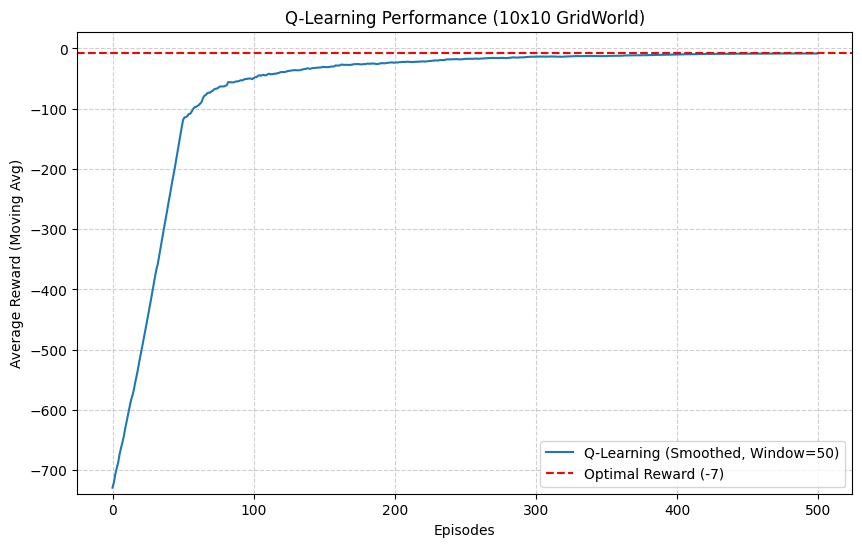

In [7]:
# Helper function for smoothing rewards
def moving_average(x, window=50):
    # Pad beginning with first value to handle initial window size
    padded_x = np.pad(x, (window-1, 0), mode='edge')
    # Calculate rolling mean
    y = np.convolve(padded_x, np.ones(window)/window, mode='valid')
    # Convert back to list of Python floats
    return [torch.tensor(val).float().item() for val in y]

# --- Calculate Smoothed Rewards & Optimal Value ---
q_rewards_smoothed = moving_average(q_rewards_list, window=50)

# Calculate optimal reward for plotting reference (shortest path)
shortest_path_len = 2 * (env.size - 1)
optimal_reward = (shortest_path_len - 1) * (-1) + 10 # (Num steps - 1)*(-1) + 1*(+10)
print(f"\nOptimal reward for {env.size}x{env.size} grid: {optimal_reward}")

# --- Plotting Q-Learning Performance ---
plt.figure(figsize=(10, 6))
plt.plot(q_rewards_smoothed, label=f"Q-Learning (Smoothed, Window=50)")
plt.axhline(y=optimal_reward, color='red', linestyle='--', label=f'Optimal Reward ({optimal_reward})')
plt.xlabel("Episodes")
plt.ylabel("Average Reward (Moving Avg)")
plt.title(f"Q-Learning Performance ({env.size}x{env.size} GridWorld)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
min_reward_smoothed = min(q_rewards_smoothed) if q_rewards_smoothed else optimal_reward - 20
plt.ylim(bottom=min(min_reward_smoothed - 10, optimal_reward - 20) )
plt.show()

#### Analyzing Q-Learning Results

The plot demonstrates that Q-learning effectively learns a good policy for this GridWorld. The smoothed average reward increases significantly and approaches the calculated optimal reward, indicating the agent is finding efficient paths to the goal.

Recall that Q-learning is **off-policy** because its update target (`reward + gamma * max(Q[next_state])`) aims for the optimal value, independent of the potentially exploratory action chosen by the epsilon-greedy policy during training.

---

### On-Policy Learning: SARSA

Q-learning aims to find the optimal Q-values, assuming future actions will be greedy (optimal). But what if we want to learn the value of the policy the agent is *actually* following, including its exploratory steps? This leads to **on-policy** learning.

A classic on-policy algorithm is **SARSA**. The name highlights the information needed for its update:
*   **S**: Current State
*   **A**: Action taken
*   **R**: Reward received
*   **S'**: Next State observed
*   **A'**: **Next Action** chosen by the *current policy* in state S'

The SARSA update rule is subtly different from Q-learning:

$$ Q(S, A) \leftarrow Q(S, A) + \alpha \left( R + \gamma Q(S', A') - Q(S, A) \right) $$

Instead of using `max Q(S', :)` in the target, SARSA uses the Q-value `Q(S', A')` corresponding to the *actual* next action `A'` that the current policy (e.g., epsilon-greedy) would choose in the next state `S'`.

### Implementing SARSA Correctly

Implementing SARSA requires careful handling of the action sequence to ensure the `A'` used in the update at time *t* is the same action `A` executed at time *t+1*. A naive implementation can easily break this.

Here's the correct implementation:

In [8]:
def sarsa(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    """
    Implements the SARSA (on-policy) algorithm for a discrete state/action environment.

    Args:
        env (GridWorld): The environment instance.
        episodes (int): The total number of episodes to train for.
        alpha (float): The learning rate.
        gamma (float): The discount factor.
        epsilon (float): The exploration rate for epsilon-greedy action selection.

    Returns:
        tuple: A tuple containing:
            - torch.Tensor: The learned Q-table (representing the value of the policy).
            - list: A list of total rewards obtained in each episode.
    """
    num_states = env.size * env.size
    num_actions = 4

    # Initialize the Q-table with zeros
    Q = torch.zeros((num_states, num_actions))

    # List to store total reward per episode
    rewards_per_episode = []

    # Main training loop over episodes
    for ep in range(episodes):
        state = env.reset()
        # **SARSA Step 1: Choose initial action A**
        action_idx = get_action(Q, state, epsilon)
        total_reward = 0
        done = False

        # Loop for each step within an episode
        while not done:
            # **SARSA Step 2: Take action A, observe R, S'**
            next_state, reward, done = env.step(action_idx)
            total_reward += reward

            # **SARSA Step 3: Choose next action A' from S' using the policy**
            next_action_idx = get_action(Q, next_state, epsilon)

            # **SARSA Step 4: Update Q(S, A) using S, A, R, S', A'**
            # Target = R + gamma * Q(S', A')
            # Note: If next_state is terminal, Q[next_state, next_action_idx] is 0.
            target_q_value = reward + gamma * Q[next_state, next_action_idx]
            Q[state, action_idx] += alpha * (target_q_value - Q[state, action_idx])

            # **SARSA Step 5: Update state and action for next iteration**
            state = next_state
            action_idx = next_action_idx # Use A' as the action for the next step

        # Episode finished, record total reward
        rewards_per_episode.append(total_reward)

    return Q, rewards_per_episode

#### Understanding the `sarsa` Function:

The key difference lies in steps 1, 3, 4, and 5 within the inner loop compared to Q-learning:
1.  The first action `A` is chosen *before* the loop starts.
2.  After observing `R` and `S'`, the *next* action `A'` is chosen using the policy (`get_action`).
3.  The Q-value update uses `Q[next_state, next_action_idx]` (the value of the action actually chosen for the next step) in the target, not `max(Q[next_state])`.
4.  Crucially, `action_idx` is updated to `next_action_idx` at the end of the loop, ensuring the action used in the update becomes the action executed in the next iteration.

---

### Running Q-Learning and SARSA Experiments

Let's train agents using both algorithms on our GridWorld and compare their performance.

Running Q-Learning for 500 episodes...
Q-Learning finished.

Running SARSA for 500 episodes...
SARSA finished.

Optimal reward for 10x10 grid: -7


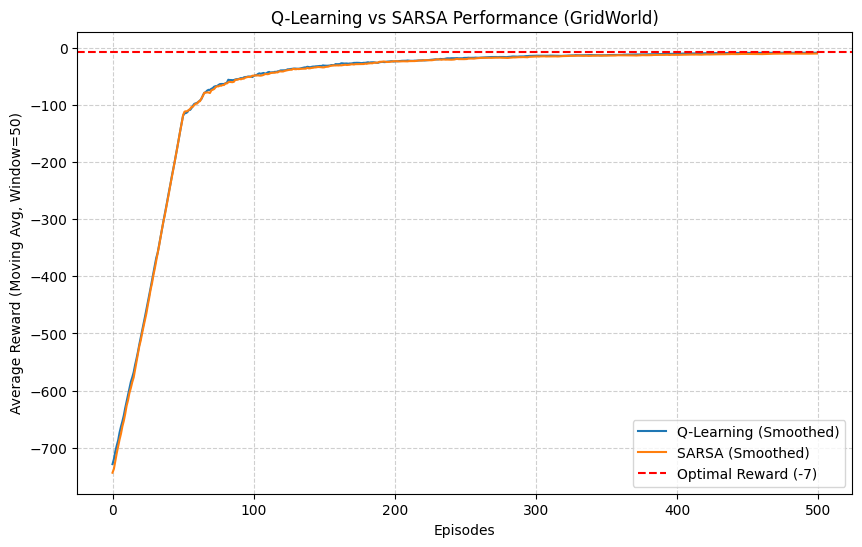

In [9]:
# Set seed for reproducibility
torch.manual_seed(42)

# Create environment
env = GridWorld(size=10)
num_episodes = 500 # Number of episodes to run

# Run Q-learning
print(f"Running Q-Learning for {num_episodes} episodes...")
q_values, q_rewards = q_learning(env, episodes=num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1)
print("Q-Learning finished.")

# Run SARSA
print(f"\nRunning SARSA for {num_episodes} episodes...")
sarsa_values, sarsa_rewards = sarsa(env, episodes=num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1)
print("SARSA finished.")

# Calculate smoothed rewards
q_rewards_smoothed = moving_average(q_rewards, window=50)
sarsa_rewards_smoothed = moving_average(sarsa_rewards, window=50)

# Determine optimal reward for plotting (shortest path calculation)
# Shortest path = (size - 1) steps right + (size - 1) steps down = 2 * (size - 1) steps
# Total reward = (Num steps - 1) * (-1) + 1 * (+10)
shortest_path_len = 2 * (env.size - 1)
optimal_reward = (shortest_path_len - 1) * (-1) + 10
print(f"\nOptimal reward for {env.size}x{env.size} grid: {optimal_reward}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(q_rewards_smoothed, label="Q-Learning (Smoothed)")
plt.plot(sarsa_rewards_smoothed, label="SARSA (Smoothed)")
plt.axhline(y=optimal_reward, color='red', linestyle='--', label=f'Optimal Reward ({optimal_reward})')
plt.xlabel("Episodes")
plt.ylabel("Average Reward (Moving Avg, Window=50)")
plt.title("Q-Learning vs SARSA Performance (GridWorld)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Analyzing Q-Learning vs. SARSA Results

Looking at the plot:
*   **Similar Performance:** In this specific deterministic GridWorld, Q-learning and SARSA perform remarkably similarly. Both algorithms quickly learn a near-optimal policy, reaching close to the maximum possible average reward.
*   **Why So Similar Here?** Because the environment is predictable (moving right always moves right unless blocked) and the optimal path is relatively clear, the epsilon-greedy policy quickly starts favoring the optimal actions. Since `epsilon` is small (0.1), the actions chosen by SARSA (`A'`) are very often the same as the greedy actions chosen implicitly by Q-learning (`max Q(S', :)`). The difference between on-policy and off-policy evaluation is less pronounced in such simple settings.

Despite their similar performance here, remember the fundamental difference:
*   **Q-Learning (Off-Policy):** Learns the value of the optimal policy, regardless of the exploration strategy used during training.
*   **SARSA (On-Policy):** Learns the value of the policy *being followed*, including the effects of exploration (e.g., epsilon-greedy).

In more complex, stochastic environments, or with different exploration strategies, the performance difference between Q-learning and SARSA can be much more significant.